In [1]:
import torch
from torch import nn
import torchvision

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.transforms import v2

from matplotlib.ticker import AutoMinorLocator, MultipleLocator


import os
import json
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from PIL import Image

import datetime

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
class MnistDtatset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.info_cls = "info"
        self.len_dataset = 0
        self.data_list = []
        if path.split("\\")[-1] == "training":
            for path_dir, dir_list, file_list in os.walk(path):
                if path_dir == path:
                    self.classes = sorted(dir_list)
                    self.class_to_idx = {
                            cls_name : i for i, cls_name in enumerate(self.classes)
                        } 
                    continue
                    
                cls = path_dir.split("\\")[-1]
                
                for name_file in file_list:
                    file_path = os.path.join(path_dir, name_file)
                    self.data_list.append((file_path, self.class_to_idx[cls]))
    
                self.len_dataset += len(file_list)
        elif path.split("\\")[-1] == "testing":
            for path_dir, dir_list, file_list in os.walk(path):
                if path_dir == path:
                    self.classes = sorted(dir_list)
                    self.class_to_idx = {
                            cls_name : i for i, cls_name in enumerate(self.classes)
                        } 
                    continue
                cls = path_dir.split("\\")[-1]
                for num, name_file in enumerate(file_list):
                    file_path = os.path.join(path_dir, name_file)
                    self.data_list.append((file_path, self.class_to_idx[cls]))
                self.len_dataset += len(file_list)
                
            
    def __len__(self):
        return self.len_dataset
        
    def __getitem__(self, index):
        file_path, target = self.data_list[index]
        sample = np.array(Image.open(file_path))

        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target 
        

In [4]:
path_train = r"C:\Users\voron\IT\pytorch\data\training"
path_test = r"C:\Users\voron\IT\pytorch\data\testing"

In [5]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.Grayscale(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5, ), std=(0.5, ))
    ]
)

In [6]:
train_data = MnistDtatset(path_train, transform=transform)
test_data = MnistDtatset(path_test, transform=transform)

In [7]:
class_to_idx = train_data.class_to_idx

In [8]:
# train_data = ImageFolder(path_train, transform=transform)
# test_data = ImageFolder(path_test, transform=transform)

In [9]:
train_data, valid_data = random_split(train_data, [0.8, 0.2])

In [10]:
bach_size = 16
train_loader = DataLoader(train_data, bach_size, shuffle=True)
val_loader = DataLoader(valid_data, bach_size, shuffle=False)
test_loader = DataLoader(test_data, bach_size, shuffle=False)


In [11]:
class MyClass(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.Layer_1 = nn.Linear(input, 128)
        self.act = nn.ReLU()
        self.Layer_2 = nn.Linear(128, output)
        
    def forward(self, x):
        x = self.Layer_1(x)
        x = self.act(x)
        out = self.Layer_2(x)
        return out


str_info="""
class MyClass(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.Layer_1 = nn.Linear(input, 128)
        self.act = nn.ReLU()
        self.Layer_2 = nn.Linear(128, output)
        
    def forward(self, x):
        x = self.Layer_1(x)
        x = self.act(x)
        out = self.Layer_2(x)
        return out

model = MyClass(64*64, 2)
opt = torch.optim.Adam(model.parameters(), lr= 0.001)
loss_model = nn.MSELoss()
"""


In [12]:
model = MyClass(28*28, 10)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_model = nn.CrossEntropyLoss()

In [13]:
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,
                                                          mode = 'min', # 'min or max' за чем следим за уменьшением или увеличением
                                                          factor=0.1, # кооф на кот будет * скорость обучения
                                                          patience=5)

In [14]:
epochs = 70
train_loss = []
train_acc = []
val_loss = []
val_acc = []
lr_list = []
best_loss = None
count = 0

In [15]:
for epoch in range(epochs):
    # тренировка модели
    model.train()
    running_train_loss = []
    true_answer = 0
    train_loop = tqdm(train_loader, leave = False)
    
    for x, targets in train_loop:
        # меняю размер данных под модель
        x = x.reshape(-1, 28*28).to(device)
        # делаю ответы в виде one-hot-encoder
        targets = targets.reshape(-1).to(torch.int32)
        targets = torch.eye(10)[targets].to(device)

        # прямой проход
        pred = model(x)
        loss = loss_model(pred, targets)

        # обратный проход
        opt.zero_grad()
        loss.backward()
        # шаг оптимизации
        opt.step()

        running_train_loss.append(loss.item())

        true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
        
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)
        train_loop.set_description(f"Epoch [{epoch+1}/{epochs}], train_loss = {mean_train_loss:.4f}")

    # расчет значения метрики
    running_train_acc = true_answer/len(train_data)

    # сохранение значения ф-и потерь и метрики
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)

    # валидация
    model.eval()
    running_val_loss = []
    true_answer = 0
    val_loop = tqdm(val_loader, leave = False)
    with torch.no_grad():
        for x, targets in val_loop:
            x = x.reshape(-1, 28*28).to(device)

            # делаю ответы в виде one-hot-encoder
            targets = targets.reshape(-1).to(torch.int32)
            targets = torch.eye(10)[targets].to(device)
            
            # прямой проход
            pred = model(x)
            loss = loss_model(pred, targets)

            true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)

        # расчет значения метрики
        running_val_acc = true_answer/len(val_loader)

        # сохранение значения ф-и потерь и метрики
        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)
        
    lr_scheduler.step(mean_val_loss)
    lr = lr_scheduler._last_lr[0]
    lr_list.append(lr)

    print(f"Epoch [{epoch+1}/{epochs}], train_loss= {mean_train_loss:.4f}, train_acc={running_train_acc:.4f}, val_loss={mean_val_loss:.4f}, val_acc={running_val_acc:.4f}, lr={lr:.4f}")
    
    if best_loss is None:
        best_loss = mean_val_loss

    if mean_val_loss < best_loss:
        best_loss = mean_val_loss
        count = 0
        save_epoch = epoch
        
        checkpoint = {
            "class_to_idx": class_to_idx,
            "info": str_info,
            "state_model": model.state_dict(),
            "state_opt": opt.state_dict(),
            "state_lr_scheduler": lr_scheduler.state_dict(),
            "loss":{
                "train_loss":train_loss,
                "val_loss": val_loss,
                "best_loss": best_loss
            },
            "metric": {
                "train_acc":train_acc,
                "val_acc": val_acc
            },
            "lr": lr_list,
            "epoch": {
                "EPOCHS": epochs,
                "save_epoch": save_epoch
            }
            
            }
        torch.save(checkpoint, f"model_state_dict_epoch_{epoch+1}.pt")
        print(f"на эпохе {epoch+1} была сохранена модель,значение ф-ии потерь на валидации: {mean_val_loss:.3f}", end="\n\n")
    
    # if mean_val_loss< best_loss- best_loss * treshold
        

    if count >=10:
        print(f"\033[31mОбучение остановленно на {epoch +1} эпохе.\033[0m")
        break
    count +=1

Epoch [1/70], train_loss= 0.3546, train_acc=0.8935, val_loss=0.1925, val_acc=15.0653, lr=0.0010


Epoch [2/70], train_loss= 0.1828, train_acc=0.9451, val_loss=0.1554, val_acc=15.2413, lr=0.0010
на эпохе 2 была сохранена модель,значение ф-ии потерь на валидации: 0.155



Epoch [3/70], train_loss= 0.1384, train_acc=0.9582, val_loss=0.1300, val_acc=15.3760, lr=0.0010
на эпохе 3 была сохранена модель,значение ф-ии потерь на валидации: 0.130



Epoch [4/70], train_loss= 0.1177, train_acc=0.9636, val_loss=0.1232, val_acc=15.4440, lr=0.0010
на эпохе 4 была сохранена модель,значение ф-ии потерь на валидации: 0.123



Epoch [5/70], train_loss= 0.1036, train_acc=0.9686, val_loss=0.1344, val_acc=15.3387, lr=0.0010


Epoch [6/70], train_loss= 0.0942, train_acc=0.9700, val_loss=0.1225, val_acc=15.4640, lr=0.0010
на эпохе 6 была сохранена модель,значение ф-ии потерь на валидации: 0.122



Epoch [7/70], train_loss= 0.0853, train_acc=0.9724, val_loss=0.1151, val_acc=15.5027, lr=0.0010
на эпохе 7 была сохранена модель,значение ф-ии потерь на валидации: 0.115



Epoch [8/70], train_loss= 0.0790, train_acc=0.9749, val_loss=0.1206, val_acc=15.4973, lr=0.0010


Epoch [9/70], train_loss= 0.0733, train_acc=0.9768, val_loss=0.1284, val_acc=15.4573, lr=0.0010


Epoch [10/70], train_loss= 0.0678, train_acc=0.9782, val_loss=0.1278, val_acc=15.4387, lr=0.0010


Epoch [11/70], train_loss= 0.0655, train_acc=0.9787, val_loss=0.1389, val_acc=15.4373, lr=0.0010


Epoch [12/70], train_loss= 0.0597, train_acc=0.9811, val_loss=0.1146, val_acc=15.5187, lr=0.0010
на эпохе 12 была сохранена модель,значение ф-ии потерь на валидации: 0.115



Epoch [13/70], train_loss= 0.0594, train_acc=0.9805, val_loss=0.1182, val_acc=15.5347, lr=0.0010


Epoch [14/70], train_loss= 0.0534, train_acc=0.9822, val_loss=0.1667, val_acc=15.3453, lr=0.0010


Epoch [15/70], train_loss= 0.0490, train_acc=0.9836, val_loss=0.1343, val_acc=15.5373, lr=0.0010


Epoch [16/70], train_loss= 0.0488, train_acc=0.9841, val_loss=0.1602, val_acc=15.4093, lr=0.0010


Epoch [17/70], train_loss= 0.0471, train_acc=0.9850, val_loss=0.1297, val_acc=15.5347, lr=0.0010


Epoch [18/70], train_loss= 0.0442, train_acc=0.9849, val_loss=0.1398, val_acc=15.5240, lr=0.0001


Epoch [19/70], train_loss= 0.0138, train_acc=0.9956, val_loss=0.0974, val_acc=15.6667, lr=0.0001
на эпохе 19 была сохранена модель,значение ф-ии потерь на валидации: 0.097



Epoch [20/70], train_loss= 0.0100, train_acc=0.9972, val_loss=0.0980, val_acc=15.6600, lr=0.0001


Epoch [21/70], train_loss= 0.0087, train_acc=0.9978, val_loss=0.0950, val_acc=15.6787, lr=0.0001
на эпохе 21 была сохранена модель,значение ф-ии потерь на валидации: 0.095



Epoch [22/70], train_loss= 0.0078, train_acc=0.9981, val_loss=0.0955, val_acc=15.6667, lr=0.0001


Epoch [23/70], train_loss= 0.0070, train_acc=0.9983, val_loss=0.0970, val_acc=15.6613, lr=0.0001


Epoch [24/70], train_loss= 0.0062, train_acc=0.9988, val_loss=0.0995, val_acc=15.6573, lr=0.0001


Epoch [25/70], train_loss= 0.0058, train_acc=0.9989, val_loss=0.1027, val_acc=15.6747, lr=0.0001


Epoch [26/70], train_loss= 0.0053, train_acc=0.9989, val_loss=0.1027, val_acc=15.6453, lr=0.0001


Epoch [27/70], train_loss= 0.0048, train_acc=0.9991, val_loss=0.1025, val_acc=15.6587, lr=0.0000


Epoch [28/70], train_loss= 0.0036, train_acc=0.9997, val_loss=0.1000, val_acc=15.6720, lr=0.0000


Epoch [29/70], train_loss= 0.0034, train_acc=0.9998, val_loss=0.0999, val_acc=15.6747, lr=0.0000


Epoch [30/70], train_loss= 0.0033, train_acc=0.9998, val_loss=0.0999, val_acc=15.6773, lr=0.0000


Epoch [31/70], train_loss= 0.0032, train_acc=0.9998, val_loss=0.1000, val_acc=15.6773, lr=0.0000
Обучение остановленно на 31 эпохе.


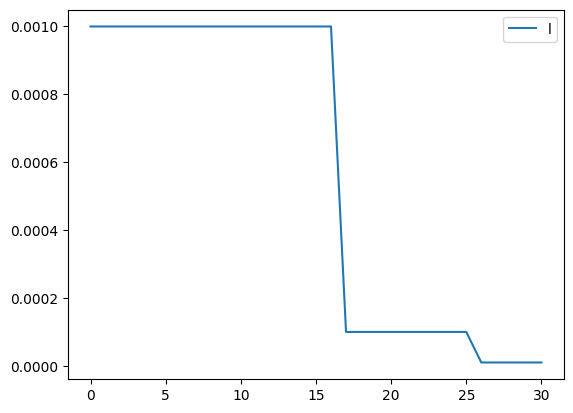

In [16]:
plt.plot(lr_list)
plt.legend("lr_list")
plt.show()

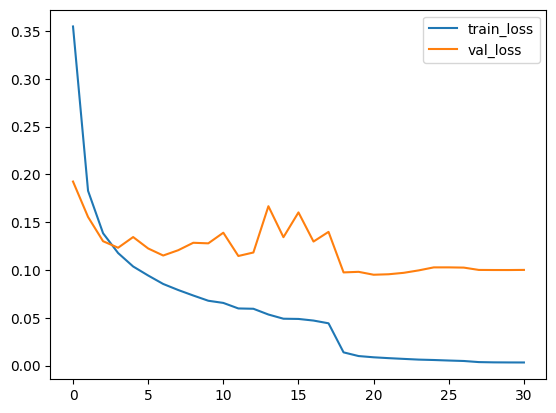

In [17]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["train_loss", "val_loss"])
plt.show()

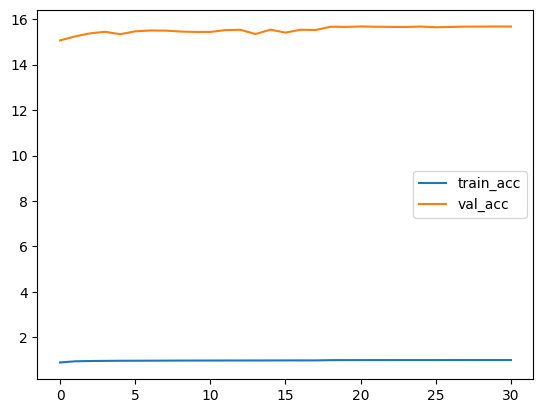

In [18]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(["train_acc", "val_acc"])
plt.show()

In [19]:
checkpoint = torch.load("model_state_dict_epoch_6.pt")
model.load_state_dict(checkpoint["state_model"])

<All keys matched successfully>

In [20]:
model.eval()
running_test_loss = []
true_answer = 0
test_loop = tqdm(test_loader, leave = False)
with torch.no_grad():
    for x, targets in test_loop:
            x = x.reshape(-1, 28*28).to(device)
            # делаю ответы в виде one-hot-encoder
            targets = targets.reshape(-1).to(torch.int32)
            targets = torch.eye(10)[targets].to(device)
            
            # прямой проход
            pred = model(x)
            loss = loss_model(pred, targets)

            running_test_loss.append(loss.item())
            mean_test_loss = sum(running_test_loss)/len(running_test_loss)

            true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()

            # расчет значения метрики
    running_test_acc = true_answer/len(test_data)
    
    print(f"test_loss= {mean_test_loss:.4f}, test_acc={running_test_acc:.4f}")
    

test_loss= 0.1225, test_acc=0.9654


### Задача регрессии

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [22]:
class EarlyStopping:
    def __init__(self, mode="min", patience=10, threshold=0.0001, threshold_mode="rel"):
        if mode not in {"min", "max"}:
            raise ValueError("Параметр mode, может принимать значения только max или min")
        if threshold_mode not in {"rel", "abs"}:
            raise ValueError("Параметр threshold_mode, может принимать значения только rel или abs")
        if not isinstance(patience, int):
            raise TypeError("Параметр patience, может быть только целым числом ")
        if not isinstance(threshold, float):
            raise TypeError("Параметр threshold, может быть только float и меньше 1.0 ")
        if threshold >= 1.0:
            raise ValueError("Параметр threshold должен быть меньше 1.0 ")

        self.mode= mode
        self.patience = patience
        self.threshold = threshold
        self.threshold_mode = threshold_mode
        self.count= 0
        self.best = None

    def __call__(self, tracked_parameter):
        current = float(tracked_parameter)
        
        if self.best is None:
            self.best = current
        return False

        if self.changed_better(current, self.best):
            self.best = current
            self.count = 0
            
        else:
            self.count += 1
            
        if self.count >= self.patience:
            self.count = 0
            return True
        return False

    def changed_better(self, current, best):
        if self.mode == "min" and self.threshold_mode == "rel":
            return current < best - best * self.threshold
            
        elif self.mode == "min" and self.threshold_mode == "abs":
            return current < best - self.threshold

        elif self.mode == "max" and self.threshold_mode == "rel":
            return current < best + best * self.threshold

        else: # self.mode == "max" and self.threshold_mode == "abs":
            return current < best + self.threshold
            
                       
        

In [23]:
class DatasetReg(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        self.list_name_file = os.listdir(path)
        if "cords.json" in self.list_name_file:
            self.list_name_file.remove("cords.json")
            
        self.len_dataset = len(self.list_name_file)
        
        with open(os.path.join(self.path, "cords.json"), "r") as f:
            self.dict_cords = json.load(f)
            
    def __len__(self):
        return self.len_dataset
        
    def __getitem__(self, index):
        name_file = self.list_name_file[index]
        path_img = os.path.join(self.path, name_file)
        
        img = Image.open(path_img)
        cord = self.dict_cords[name_file]
        # cords = torch.tensor(self.dict_cords[name_file], dtype= torch.float32)

        if self.transform is not None:
            img = self.transform(img)
            cord = torch.tensor(cord, dtype=torch.float32)
        return img, cord
        

In [24]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=(0.5,), std=(0.5,),)
    ]
)

In [25]:
dataset = DatasetReg(path = r"C:\Users\voron\IT\pytorch\dataset", transform=transform)

In [26]:
train_data, valid_data, test_data = random_split(dataset, [0.7, 0.1, 0.2])

In [27]:
bach_size = 32
train_loader = DataLoader(train_data, bach_size, shuffle=True)
val_loader = DataLoader(valid_data, bach_size, shuffle=False)
test_loader = DataLoader(test_data, bach_size, shuffle=False)


In [28]:
model = MyClass(64*64, 2)
opt = torch.optim.Adam(model.parameters(), lr= 0.001)
loss_model = nn.MSELoss()
earlystopping = EarlyStopping(mode="min", patience=10)

In [29]:
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,
                                                          mode = 'min', # 'min or max' за чем следим за уменьшением или увеличением
                                                          factor=0.1, # кооф на кот будет * скорость обучения
                                                          patience=5)

In [30]:
epochs = 100
train_loss = []
train_acc = []
val_loss = []
val_acc = []
lr_list = []
best_loss = None


In [ ]:
for epoch in range(epochs):
    # тренировка модели
    model.train()
    running_train_loss = []
    true_answer = 0
    train_loop = tqdm(train_loader, leave = False)
    
    for x, targets in train_loop:
        # меняю размер данных под модель
        x = x.reshape(-1, 64*64).to(device)

        # делаю ответы в виде one-hot-encoder
        targets = targets.to(device)

        # прямой проход
        pred = model(x)
        loss = loss_model(pred, targets)

        # обратный проход
        opt.zero_grad()
        loss.backward()
        # шаг оптимизации
        opt.step()

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)

        true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()
        
        
        train_loop.set_description(f"Epoch [{epoch+1}/{epochs}], train_loss = {mean_train_loss:.4f}")

    # расчет значения метрики
    running_train_acc = true_answer/len(train_data)

    # сохранение значения ф-и потерь и метрики
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)

    # валидация
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        true_answer = 0
        val_loop = tqdm(val_loader, leave = False)
    
        for x, targets in val_loop:
            x = x.reshape(-1, 64*64).to(device)
            targets = targets.to(device)
            
            # прямой проход
            pred = model(x)
            loss = loss_model(pred, targets)

            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)
            
            true_answer += (torch.round(pred) == targets).all(dim=1).sum().item()

            
            

        # расчет значения метрики
        running_val_acc = true_answer/len(valid_data)

        # сохранение значения ф-и потерь и метрики
        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)
        
    lr_scheduler.step(mean_val_loss)
    lr = lr_scheduler._last_lr[0]
    lr_list.append(lr)

    print(f"Epoch [{epoch+1}/{epochs}], train_loss= {mean_train_loss:.4f}, train_acc={running_train_acc:.4f}, val_loss={mean_val_loss:.4f}, val_acc={running_val_acc:.4f}, lr={lr:.4f}")
    
    if best_loss is None:
        best_loss = mean_val_loss
        
    # if mean_val_loss< best_loss- best_loss * treshold
    if mean_val_loss < best_loss:
        best_loss = mean_val_loss
    
        checkpoint = {
            "info": str_info,
            "state_model": model.state_dict(),
            "state_opt": opt.state_dict(),
            "state_lr_scheduler": lr_scheduler.state_dict(),
            "loss":{
                "train_loss":train_loss,
                "val_loss": val_loss,
                "best_loss": best_loss
            },
            "metric": {
                "train_acc":train_acc,
                "val_acc": val_acc
            },
            "lr": lr_list,
            "epoch": {
                "EPOCHS": epochs,
                "save_epoch": epoch
            }
            
            }
        torch.save(checkpoint, f"model_state_dict_epoch_{epoch+1}.pt")
        print(f"на эпохе {epoch+1} была сохранена модель,значение ф-ии потерь на валидации: {mean_val_loss:.3f}", end="\n\n")
        # print(f"на эпохе {epoch+1} была сохранена модель,значение точности на валидации: {running_val_acc:.3f}", end="\n\n")

    if earlystopping(mean_val_loss):
        print(f"\033[31mОбучение остановленно на {epoch +1} эпохе.\033[0m")
        break

Epoch [1/100], train_loss= 26.9733, train_acc=0.0254, val_loss=25.6847, val_acc=0.0400, lr=0.0010


Epoch [2/100], train_loss= 24.7232, train_acc=0.0260, val_loss=24.1874, val_acc=0.0147, lr=0.0010
на эпохе 2 была сохранена модель,значение ф-ии потерь на валидации: 24.187



Epoch [3/100], train_loss= 24.7545, train_acc=0.0200, val_loss=25.3184, val_acc=0.0000, lr=0.0010


Epoch [4/100], train_loss= 24.6483, train_acc=0.0204, val_loss=24.8524, val_acc=0.0281, lr=0.0010


Epoch [5/100], train_loss= 24.5752, train_acc=0.0210, val_loss=24.3470, val_acc=0.0218, lr=0.0010


Epoch [6/100], train_loss= 24.4559, train_acc=0.0227, val_loss=25.0885, val_acc=0.0005, lr=0.0010


Epoch [7/100], train_loss= 24.4046, train_acc=0.0226, val_loss=24.2441, val_acc=0.0361, lr=0.0010


Epoch [8/100], train_loss= 24.3957, train_acc=0.0244, val_loss=24.0381, val_acc=0.0405, lr=0.0010
на эпохе 8 была сохранена модель,значение ф-ии потерь на валидации: 24.038



Epoch [9/100], train_loss= 24.3347, train_acc=0.0243, val_loss=24.4424, val_acc=0.0055, lr=0.0010


Epoch [10/100], train_loss= 24.3026, train_acc=0.0266, val_loss=25.5556, val_acc=0.0000, lr=0.0010


Epoch [11/100], train_loss= 24.3073, train_acc=0.0238, val_loss=24.3226, val_acc=0.0048, lr=0.0010


Epoch [12/100], train_loss= 24.2923, train_acc=0.0225, val_loss=24.1774, val_acc=0.0137, lr=0.0010


Epoch [13/100], train_loss= 24.2096, train_acc=0.0268, val_loss=23.9951, val_acc=0.0375, lr=0.0010
на эпохе 13 была сохранена модель,значение ф-ии потерь на валидации: 23.995



Epoch [14/100], train_loss= 24.2473, train_acc=0.0231, val_loss=23.9860, val_acc=0.0417, lr=0.0010
на эпохе 14 была сохранена модель,значение ф-ии потерь на валидации: 23.986



Epoch [15/100], train_loss= 24.1918, train_acc=0.0250, val_loss=24.2597, val_acc=0.0103, lr=0.0010


Epoch [16/100], train_loss= 24.1679, train_acc=0.0271, val_loss=25.0481, val_acc=0.0364, lr=0.0010


Epoch [17/100], train_loss= 24.1512, train_acc=0.0268, val_loss=24.4399, val_acc=0.0013, lr=0.0010


Epoch [18/100], train_loss= 24.1358, train_acc=0.0267, val_loss=24.3525, val_acc=0.0388, lr=0.0010


Epoch [19/100], train_loss= 24.0900, train_acc=0.0277, val_loss=24.4316, val_acc=0.0044, lr=0.0010


Epoch [20/100], train_loss= 24.1353, train_acc=0.0258, val_loss=24.8846, val_acc=0.0341, lr=0.0001


Epoch [21/100], train_loss= 23.7294, train_acc=0.0401, val_loss=23.9964, val_acc=0.0401, lr=0.0001


Epoch [22/100], train_loss= 23.7214, train_acc=0.0403, val_loss=24.0459, val_acc=0.0411, lr=0.0001


Epoch [23/100], train_loss= 23.6927, train_acc=0.0408, val_loss=24.0646, val_acc=0.0405, lr=0.0001


Epoch [24/100], train_loss= 23.6858, train_acc=0.0420, val_loss=24.0194, val_acc=0.0430, lr=0.0001


Epoch [25/100], train_loss= 23.6736, train_acc=0.0419, val_loss=23.9808, val_acc=0.0404, lr=0.0001
на эпохе 25 была сохранена модель,значение ф-ии потерь на валидации: 23.981



Epoch [26/100], train_loss= 23.6518, train_acc=0.0427, val_loss=23.9829, val_acc=0.0410, lr=0.0001


Epoch [27/100], train_loss= 23.6358, train_acc=0.0420, val_loss=24.1680, val_acc=0.0419, lr=0.0001


Epoch [28/100], train_loss= 23.6156, train_acc=0.0418, val_loss=23.9868, val_acc=0.0417, lr=0.0001


Epoch [29/100], train_loss= 23.6075, train_acc=0.0417, val_loss=24.0097, val_acc=0.0424, lr=0.0001


Epoch [30/100], train_loss= 23.5808, train_acc=0.0430, val_loss=24.0790, val_acc=0.0423, lr=0.0001


Epoch [31/100], train_loss= 23.5731, train_acc=0.0418, val_loss=24.0587, val_acc=0.0425, lr=0.0000


Epoch [32/100], train_loss= 23.5125, train_acc=0.0426, val_loss=24.0346, val_acc=0.0432, lr=0.0000


Epoch [33/100], train_loss= 23.5113, train_acc=0.0427, val_loss=23.9950, val_acc=0.0413, lr=0.0000


Epoch [34/100], train_loss= 23.5088, train_acc=0.0422, val_loss=24.0098, val_acc=0.0418, lr=0.0000


Epoch [35/100], train_loss = 23.7191:  10%|███▉                                     | 213/2188 [00:08<01:19, 24.95it/s]